# Gromov-Wasserstein for multi-omics

A [variety of single-cell measurements](https://en.wikipedia.org/wiki/Single-cell_analysis) can help explore cell characteristics that are helpful to understand biological mechanisms. These measurements can for instance [describe epigenetic changes](https://en.wikipedia.org/wiki/Single_cell_epigenomics) (DNA methylation, chromatin accessibility, histone modifications, chromosome conformation), the genome itself, as well as the proteins present in the cell ([single cell sequencing](https://en.wikipedia.org/wiki/Single_cell_sequencing). However, performing measures of different natures rises a major challenge: that of establishing an alignment across two (possibly several) measurement spaces that are unrelated, in the sense that no biological-based theory allows to construct such correspondences between them. In the absence of supervised information, the alignment can be constructed from first-hand principles, such as that of preserving geometry (i.e. an isomorphism) between the two measurement spaces. Indeed, since the population of cells measured is (statistically) the same across measurements, we expect that cells with similar genomes will be mapped to cells with similar transcriptomes, proteomes and epigenetic changes. 

The Gromov-Wasserstein optimal transport framework, implemented in OTT, is a relevant candidate to perform such an unsupervised cell alignment. 
This approach was proposed by {cite}`demetci:22`, who called it SCOT ([GitHub repo](https://github.com/rsinghlab/SCOT)), from which this notebook is adapted.

The original SCOT code code uses [Python Optimal Transport (POT)](https://pythonot.github.io/). Here, we propose a slight modification of the SCOT code to use the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver, which we have found to be faster than the POT implementation of {func}`~ot.gromov.entropic_gromov_wasserstein` on GPU (see [](#alignment-and-evaluation)). We then use this OTT version of the SCOT algorithm to perform cell alignment for the SNARE-seq dataset {cite}`chen:19`, which contains measures of two natures:

 - Chromatin accessibility ([scATAC-seq data](https://en.wikipedia.org/wiki/ATAC-seq))
 - Gene expression ([scRNA-seq data](https://en.wikipedia.org/wiki/Single_cell_sequencing#scRNA-Seq))

## Imports and dataset loading 

We must clone the SCOT repo within the folder that contains this notebook. For later access to data present in the cloned repo, only relative paths are used.

In [ ]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install -q seaborn
    !git clone -q https://github.com/rsinghlab/SCOT
    !pip install -r SCOT/src/requirements.txt

In [1]:
import time

from SCOT.src import evals
from SCOT.src.scot import SCOT

import numpy as np
import pandas as pd
from ot.gromov import gwloss, init_matrix
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
from matplotlib import animation

import ott
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein

In [2]:
X = np.load("SCOT/data/scatac_feat.npy")
y = np.load("SCOT/data/scrna_feat.npy")

print("Dimensions of input datasets:")
print(
    "X =",
    X.shape,
    "=> ie",
    X.shape[0],
    "samples belonging to a chromatin accessibility feature space of dimension",
    X.shape[1],
)
print(
    "y =",
    y.shape,
    "=> ie",
    y.shape[0],
    "samples belonging to a gene expression feature space of dimension",
    y.shape[1],
)

Dimensions of input datasets:
X = (1047, 19) => ie 1047 samples belonging to a chromatin accessibility feature space of dimension 19
y = (1047, 10) => ie 1047 samples belonging to a gene expression feature space of dimension 10


## Using `gromov_wasserstein` from OTT

The following `OTTSCOT` class inherits from the `SCOT` class but overrides the `find_correspondences` method in order to use OTT instead of POT. The matrix `T` is the optimal transport matrix, mapping $X$ to $y$.

In [5]:
class OTTSCOT(SCOT):
    def find_correspondences(self, e: float, verbose: bool = True) -> None:
        geom_xx = ott.geometry.Geometry(self.Cx)
        geom_yy = ott.geometry.Geometry(self.Cy)
        prob = quadratic_problem.QuadraticProblem(
            geom_xx, geom_yy, a=self.p, b=self.q
        )

        solver = gromov_wasserstein.GromovWasserstein(
            epsilon=e, threshold=1e-9, max_iterations=1000
        )

        T = solver(prob).matrix

        constC, hC1, hC2 = init_matrix(
            self.Cx, self.Cy, self.p, self.q, loss_fun="square_loss"
        )
        self.gwdist = gwloss(constC, hC1, hC2, np.array(T))
        self.coupling = T

        if (
            np.isnan(self.coupling).any()
            or np.any(~self.coupling.any(axis=1))
            or np.any(~self.coupling.any(axis=0))
            or sum(sum(self.coupling)) < 0.95
        ):
            self.flag = False
        else:
            self.flag = True

In the Gromov-Wassertein optimal transport, we have two hyperparameters to tune : 
- $\epsilon$, which controls entropy in the regularized optimization problem 
- $k$, that is the number of nearest neighbours that we will consider for building the initial graphs that will allow us to define a notion of closeness between points from the same domain

The `SCOT` class implements an unsupervized hyperparmeter search method which for our `OTTSCOT` outputs optimal values of `1e-3` for $\epsilon$ and `40` for the  number of neighbors $k$ . We will retain these values for the rest of the exploration of the SNARE-seq dataset:

In [6]:
k = 40
epsilon = 1e-3

Besides, note that for a fair comparison between `POT` and `OTT`, we have set the maximum number of iterations for OTT's Gromov to be equal to `1000` and the error threshold at `1e-9`, the default values of the POT version of Gromov used in SCOT.

## Alignment and evaluation

We now perform the alignment for our dataset and evaluate its execution time (on Colab, using a Tesla P100 GPU):

In [10]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b22fbca2-02fb-5ce3-8143-b4aafdc5de09)


In [7]:
ottscot = OTTSCOT(X, y)

start = time.time()
X_shifted, y_shifted = ottscot.align(
    k=k, e=epsilon, normalize=True, norm="l2", verbose=False
)  # OTT
end = time.time()

print("Execution time: ", round(end - start, 2), "s")

Execution time:  18.29 s


For comparison purposes, we also evaluate excecution time for the original SCOT algorithm using POT (on the same GPU):

In [8]:
potscot = SCOT(X, y)

start = time.time()
X_shifted_pot, y_shifted_pot = potscot.align(
    k=k, e=epsilon, normalize=True, norm="l2", verbose=False
)  # POT
end = time.time()

print("Execution time: ", round(end - start, 2), "s")

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Execution time:  145.98 s


For this run on GPU, OTT's {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver is about 8 times faster than POT's solver. OTT's GW greatly benefits from parallelization, so its advantage over POT's GW should also be tested on CPU.


We are provided with a ground truth alignment, since we have the identity of each cell for the two domains. The fraction of samples closer than the true match (FOSCTTM) is a metric used in SCOT that leverages this supervision information to evaluate alignments (higher is better). We can use it to further compare alignments obtained with OTT and POT :

In [19]:
fractions = evals.calc_domainAveraged_FOSCTTM(X_shifted, y_shifted)  # OTT
print(
    "The average FOSCTTM for the alignment of X (chromatine accessibility domain)"
    " on y (gene expression domain) is: ",
    np.mean(fractions).round(4),
)

The average FOSCTTM for the alignment of X (chromatine accessibility domain) on y (gene expression domain) is:  0.2255


In [20]:
fractions_pot = evals.calc_domainAveraged_FOSCTTM(
    X_shifted_pot, y_shifted_pot
)  # POT
print(
    "The average FOSCTTM for the alignment of X (chromatine accessibility domain)"
    " on y (gene expression domain) is: ",
    np.mean(fractions_pot).round(4),
)

The average FOSCTTM for the alignment of X (chromatine accessibility domain) on y (gene expression domain) is:  0.2247


FOSCTTM are very close for the two alignements, and the OTT version is even slightly better.

## Visualisations

We begin by taking a look at the 2-Principal Components Analyses of both domains :

Text(0.5, 1.0, 'PCA of gene expression before alignment, \n colored according to cell type')

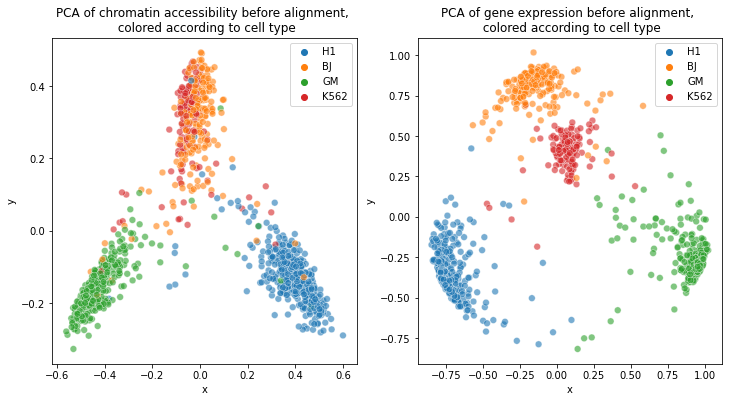

In [21]:
cellTypes_atac = np.loadtxt("SCOT/data/SNAREseq_atac_types.txt")
cellTypes_rna = np.loadtxt("SCOT/data/SNAREseq_rna_types.txt")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(ottscot.X)

cell_types = list(set(cellTypes_atac))
cell_types_names = ["H1", "GM", "BJ", "K562"]
colors = ["blue", "purple", "red", "green"]

df1 = pd.DataFrame(
    {
        "x": np.flip(X_pca[:, 0]),
        "y": np.flip(X_pca[:, 1]),
        "cellTypes": np.flip(
            [cell_types_names[int(type) - 1] for type in cellTypes_atac]
        ),
    }
)

sn.scatterplot(
    data=df1,
    x="x",
    y="y",
    hue="cellTypes",
    s=45,
    alpha=0.6,
    edgecolors="none",
    ax=ax1,
)
ax1.legend()
ax1.set_title(
    "PCA of chromatin accessibility before alignment, \n colored according to cell type"
)

pca = PCA(n_components=2)
y_pca = pca.fit_transform(ottscot.y)
df1 = pd.DataFrame(
    {
        "x": np.flip(y_pca[:, 0]),
        "y": np.flip(y_pca[:, 1]),
        "cellTypes": np.flip(
            [cell_types_names[int(type) - 1] for type in cellTypes_rna]
        ),
    }
)

sn.scatterplot(
    data=df1,
    x="x",
    y="y",
    hue="cellTypes",
    s=45,
    alpha=0.6,
    edgecolors="none",
    ax=ax2,
)

ax2.legend()
ax2.set_title(
    "PCA of gene expression before alignment, \n colored according to cell type"
)

We visualize the superposition of chromatin accessibility points mapped to gene expression domain to the original points cloud of gene expression data :

In [22]:
fig = plt.figure(figsize=(9, 9))
(line,) = plt.plot([], [])

n_samples = len(X)
pca = PCA(n_components=2)

Xy_pca = pca.fit_transform(np.concatenate((X_shifted, y_shifted), axis=0))

cell_types = list(set(cellTypes_atac))
cell_types_names = ["H1", "GM", "BJ", "K562"]
cellTypes_atac_rna = np.concatenate(
    (
        [cell_types_names[int(type) - 1] for type in cellTypes_atac],
        [cell_types_names[int(type) - 1] for type in cellTypes_rna],
    ),
    axis=0,
)
original_domain_type = np.concatenate(
    (
        np.full(n_samples, "Chromatin accessibility"),
        np.full(n_samples, "Gene expression"),
    ),
    axis=0,
)

df = pd.DataFrame(
    {
        "x": np.flip(Xy_pca[:, 0]),
        "y": np.flip(Xy_pca[:, 1]),
        "cellTypes": np.flip(cellTypes_atac_rna),
        "original_domain": np.flip(original_domain_type),
    }
)


def animate(i):
    plt.clf()
    if i == 0:
        sn.scatterplot(
            data=df1,
            x="x",
            y="y",
            hue="cellTypes",
            s=70,
            alpha=0.6,
            edgecolors="none",
        )
        plt.title(
            "PCA of gene expression before alignment, \n colored according to cell type"
        )
    else:
        sn.scatterplot(
            data=df,
            x="x",
            y="y",
            hue="cellTypes",
            s=70,
            style="original_domain",
            alpha=0.6,
            edgecolors="none",
        )
        plt.title(
            "PCA of chromatin accessibility points mapped to gene expression domain,\n"
            "along with original gene expression points,\n"
            "colored according to cell type"
        )
    return (line,)


def init():
    line.set_data([], [])
    return (line,)


anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[0, 1],
    interval=1500,
    blit=True,
)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

We can perform many more visualisations with animated plots. An example provided below explores the visual evolution of the optimal transport when we vary the hyperparameter $k$ (the number of neighbours):

In [23]:
k_values = [10, 20, 40, 80, 100]
pointclouds_pairs = []
for k in k_values:
    X_new, y_new = ottscot.align(k=k, e=1e-3, normalize=True, norm="l2")
    pointclouds_pairs.append((X_new, y_new))

In [24]:
fig = plt.figure(figsize=(9, 9))
(line,) = plt.plot([], [])


def animate(i):
    plt.clf()
    k = k_values[i]
    (X_new, y_new) = pointclouds_pairs[i]
    pca = PCA(n_components=2)
    Xy_pca = pca.fit_transform(np.concatenate((X_new, y_new), axis=0))

    df_new = pd.DataFrame(
        {
            "x": np.flip(Xy_pca[:, 0]),
            "y": np.flip(Xy_pca[:, 1]),
            "cellTypes": np.flip(cellTypes_atac_rna),
            "original_domain": np.flip(original_domain_type),
        }
    )

    sn.scatterplot(
        data=df_new,
        x="x",
        y="y",
        hue="cellTypes",
        s=70,
        style="original_domain",
        alpha=0.6,
        edgecolors="none",
    )

    plt.title(
        "PCA of chromatin accessibility points mapped to gene expression domain, \n \
        along with original gene expression points for k="
        + str(k)
    )

    return (line,)


def init():
    line.set_data([], [])
    return (line,)


anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=list(range(5)),
    interval=1500,
    blit=True,
)


html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()